In [8]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [11]:
import os
from zipfile import ZipFile

zip_file_path = '/content/drive/MyDrive/FaceExpressions.zip'
extraction_directory = '/content/drive/MyDrive/'

# Unzipping the file
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_directory)

# Deleting 'data.csv' and 'Ahegao' directory as they are not needed
os.remove(os.path.join(extraction_directory, 'data.csv'))
import shutil
shutil.rmtree(os.path.join(extraction_directory, 'dataset/Ahegao'))  # Deleting Ahegao directory

# Listing the remaining files and directories to verify if they exist
remaining_files_dirs = os.listdir(os.path.join(extraction_directory, 'dataset'))
print(remaining_files_dirs)


['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']


In [12]:
from keras.preprocessing.image import ImageDataGenerator

# Define paths
dataset_dir = '/content/drive/MyDrive/dataset'

# Initialize the ImageDataGenerator for training data with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Image rescaling
    shear_range=0.2,  # Shearing
    zoom_range=0.2,   # Zooming
    horizontal_flip=True,  # Horizontal flipping
    rotation_range=20,  # Random rotations within 20 degrees
    validation_split=0.2  # Splitting data
)

# Initialize the ImageDataGenerator for test/validation data (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Prepare the training dataset
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Prepare the validation dataset
validation_generator = test_datagen.flow_from_directory(
    dataset_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)



Found 11401 images belonging to 5 classes.
Found 2847 images belonging to 5 classes.


In [4]:
import os
import glob


dataset_dir = '/content/drive/MyDrive/dataset'

categories = ['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Looping through each category and count the images
for category in categories:
    # Constructing the path to the category's directory
    category_path = os.path.join(dataset_dir, category)

    # Use glob to find all image files in the directory
    images = glob.glob(category_path + '/*')

    # Print the count
    print(f"{category}: {len(images)} images")


Angry: 1313 images
Happy: 3668 images
Neutral: 4027 images
Sad: 3934 images
Surprise: 1234 images


In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.backend import clear_session

# Clear any previous model from memory
clear_session()

# Initialize the CNN
model = Sequential()

# Convolutional Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(128, 128, 3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional Layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flattening
model.add(Flatten())

# Fully Connected Layer 1
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))

# Fully Connected Layer 2 (Output Layer)
print(f"Number of classes: {train_generator.num_classes}")
model.add(Dense(units=train_generator.num_classes, activation='softmax'))

# Compiling the CNN
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()

# Fitting the CNN to the images
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=15
)


Number of classes: 5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None,

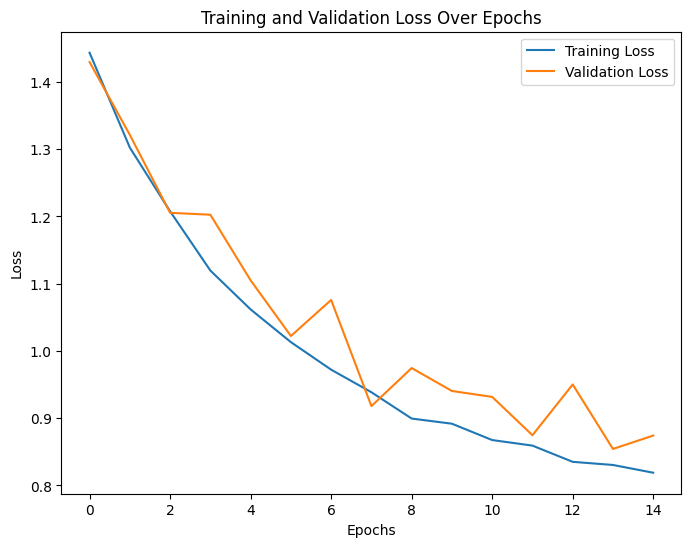

In [17]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


89/89 [==============================] - 46s 502ms/step


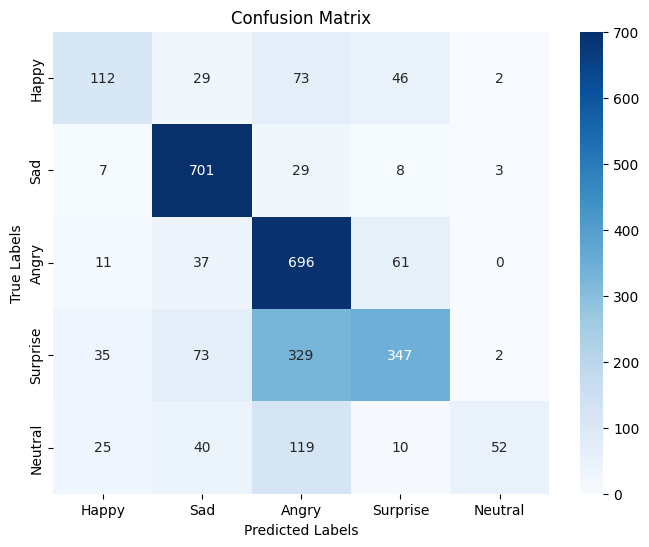

In [21]:

validation_generator.shuffle = False
validation_generator.reset()

y_pred_prob = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred_prob, axis=1)


y_true_classes = validation_generator.classes

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [22]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(y_true_classes, y_pred_classes, target_names=classes))


              precision    recall  f1-score   support

       Happy       0.59      0.43      0.50       262
         Sad       0.80      0.94      0.86       748
       Angry       0.56      0.86      0.68       805
    Surprise       0.74      0.44      0.55       786
     Neutral       0.88      0.21      0.34       246

    accuracy                           0.67      2847
   macro avg       0.71      0.58      0.59      2847
weighted avg       0.70      0.67      0.65      2847



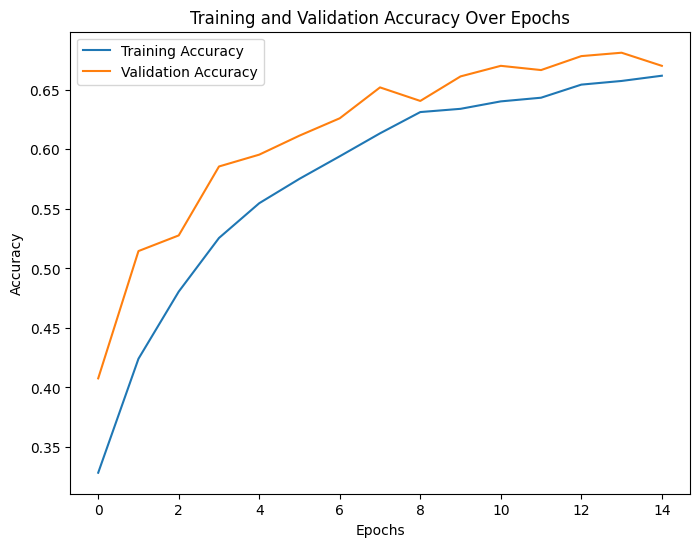

In [19]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [23]:
# Evaluate on validation set, doing it on val set because I forgot to include a test set in the begining and the training time took over 2hrs so dont want to repeat everything again
val_scores = model.evaluate(validation_generator, verbose=0)
print(f'Validation set performance: {model.metrics_names[0]} of {val_scores[0]}; {model.metrics_names[1]} of {val_scores[1]*100}%')


Validation set performance: loss of 0.8713253736495972; accuracy of 67.01791286468506%


In [25]:
model_save_path = "/content/drive/My Drive/DL_CNN_Model_Q3.keras"
model.save(model_save_path)
